## Phylogenetic Analysis

The goal of this notebook is to perform phylogenetic inference on the samples from the boat as well as other genomes sampled from around the same time as the boat outbreak. 

In [259]:
from Bio import SeqIO, AlignIO, SeqRecord, Seq # Parse fasta files 
from itertools import combinations # Handle pairwise comparisons
from collections import Counter # Count instances in a list
from ete3 import Tree # Tree visualization
import pandas as pd
from io import StringIO 

# Make sure mafft is in the conda/local env
from Bio.Align.Applications import MafftCommandline


To make the consensus sequences, I took each `BAM` file and counted the occurences of each nucleotide at every position. If there were less than 100 reads that covered a given site (with `BQ > 25`) then I coded this site as an `N`. Then, using both replicates, I filled in missing (`N`) nucleotides with the more highly covered positions. 

This method doesn't take into account insertions and deletions. That could be a bit of a shortcoming, however, I can also include insertions and deletions if necessary. Since I'm mostly focused on SNPs in the intrahost population, I thoguht this was a reasonable oversight.

In [132]:
# Path to the aligned sequences
boat_genomes_path = "../../results/consensus/aligned_consensus.fa"
# Put the sequence records and ids into a dictionary structure
boat_genomes = {record.id : record.seq for record in SeqIO.parse(boat_genomes_path, "fasta")}

#### Edit Distance

Here is the edit distance (hamming distance) between each of the genomes. The most divergent sample is `10136`. We know that this sample probably wasn't infected by the same virus that spread on the boat. It also doesn't seem like any of the cases on the boat came from this person. 

In [133]:
distance = lambda x,y : sum(c1 != c2 for c1, c2 in zip(x, y))

edit_distance = {f"{g1}-{g2}": distance(boat_genomes[g1], boat_genomes[g2]) for g1, g2 in combinations(boat_genomes.keys(), 2)}
outlier_distance = {f"{g1}-{g2}": distance(boat_genomes[g1], boat_genomes[g2]) for g1, g2 in combinations(boat_genomes.keys(), 2) if g1 == '10136' or g2 == '10136'}

print(f"The mean pairwise distance between samples is {sum(v for v in edit_distance.values()) / len(edit_distance):.2f}.\n")
print(f"However, this includes a sample (10136) that is highly diverged from the rest with a mean edit distance of {sum(v for v in outlier_distance.values()) / len(outlier_distance):.2f} from any other sample.")



The mean pairwise distance between samples is 2.13.

However, this includes a sample (10136) that is highly diverged from the rest with a mean edit distance of 8.83 from any other sample.


#### Consensus Differences 

Here are all the differences between the 24 patients and the reference (Wuhan-1). I collapsed patients with the same consensus sequecnes into a single row. A better way to visualize this might be to add it to a phylogenetic tree of the samples on the boat as an annotation. 

Some of these sites are different from the reference, but the same in all 24 individuals (boat consensus mutations). I could either include or exclude these from the visualization. I'm not sure what's most prudent. 

In [134]:
# Reference Sequence 
reference = [base for record in SeqIO.parse("../../config/ref/SARS2.fa", "fasta") for base in record.seq]

# Save a dict of the consensus SNPs for each patient
consesus = {}

# Populate the dict
for patient, genome in boat_genomes.items():
    differences = []
    for i, bases in enumerate(zip(genome.upper(), reference)):
        if len(set(bases)) > 1: 
            differences.append((i, bases))
    consesus[patient] = differences

# Get a set of all unique SNPs 
consensus_differences = set(snp for snp_list in consesus.values() for snp in snp_list)

# Fill in the missing SNPs in the dict
for patient, snps in consesus.items(): 
    for snp in consensus_differences: 
        if snp not in snps:
            consesus[patient].append((snp[0], (snp[1][1], snp[1][1])))


# Condense the identical sequences
unique_consensus = {}

for patient, snps in consesus.items(): 
    con = ' '.join([snp[1][0] for snp in sorted(snps, key = (lambda s: s[0]))])
    if con in unique_consensus.keys():
        unique_consensus[con].append(patient)
    else: 
        unique_consensus[con] = [patient]

# Print the differences for each patient 
print(f"Position: {' '.join([str(snp[0]) for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")
print(f"Reference: \t\t\t\t{' '.join([snp[1][1] for snp in sorted(consensus_differences, key = (lambda s: s[0]))])}")

for snps, patients in unique_consensus.items(): 
    print(f"{'/'.join(patients)}: \t\t\t\t\t{snps}")


Position: 240 538 1058 1254 3036 6045 7563 8289 11082 13251 13422 14407 16911 17124 17155 17351 19523 23402 25562 27310 28375 29166 29298 29552 29867 29869
Reference: 				C C C A C T C C G C C C G C C C C A G T G C A G G C
10114: 					T C T A T T T C T C C T G C C C T G T T T C A G G A
10117/10118/10127/10130/10027/10040/10089/10091/10102/10110: 					T C T A T T T C T C C T G C C C C G T T T C A G G A
10128: 					T C T A T T T T T C C T G T C C C G T T T C A G G A
10129: 					T C T A T T T T T C C T G C C C C G T T T C A G G C
10131: 					T T T A T T T C T C C T G C C C C G T C T C A G G A
10136: 					T C T G T C C C G C C T T C T C C G T T G C A A G A
10138: 					T C T A T T T C T C C T G C C C C G T T T C T G G A
10028: 					T C T A T T T T T C C T G C C C C G T T T C A G A A
10029/10094/10106: 					T C T A T T T C T C C T G C C C C G T T T C A G A A
10039: 					T C T A T T T C T C C T G C C C C G T T T T A G A A
10042: 					T C T A T T T C T C T T G C C T C G T T T C A G G A
10088: 

#### Boat Consensus 

These are the mutations that are different from the reference, but shared between all 24 people we've analyzed on the boat. 

In [163]:
# Consensus in all samples including divergent 10136
all_boat_consensus = []
for k,v in Counter(snp for snps in consesus.values() for snp in snps).items():
    if v == 24:
        all_boat_consensus.append(k)
    
# Consensus in all samples EXCLUDING divergent 10136
true_boat_consensus = []
for k,v in Counter(snp for patient, snps in consesus.items() if patient != "10136" for snp in snps).items():
    if v == 23:
        true_boat_consensus.append(k)

print(f"Mutations found in every patient including 10136:\n\t{[''.join([alleles[0], str(pos), alleles[1]]) for pos, alleles in all_boat_consensus]}\n")
print(f"Mutations found in every patient EXCLUDING 10136:\n\t{[''.join([alleles[0], str(pos), alleles[1]]) for pos, alleles in true_boat_consensus]}\n")



Mutations found in every patient including 10136:
	['T240C', 'T1058C', 'T3036C', 'T14407C', 'G23402A', 'T25562G']

Mutations found in every patient EXCLUDING 10136:
	['T240C', 'T1058C', 'T3036C', 'T7563C', 'T11082G', 'T14407C', 'G23402A', 'T25562G', 'T28375G', 'C17155C', 'G16911G', 'G29552G', 'A1254A', 'T6045T']



#### Phylogenetic Tree

Here I make a tree from the consensus samples deep-sequenced from the boat. The tree was made using IQtree's automatic model using the commad `iqtree -s {input}`. 

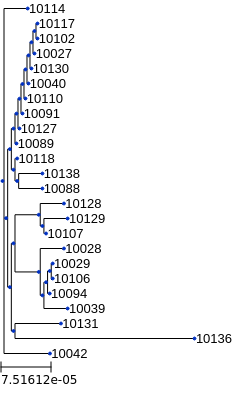

In [178]:
t = Tree("../../results/consensus/aligned_consensus.fa.treefile")

t.render("%%inline")  

These are just the sequences on the boat that we have replicate deep-sequencing runs for. It's also important to look at the remaining sequences (15 samples with Ct > 20). Also, I want to see where these sequences fall in the global phylogeny as well as the local washington phylogeny. 

Here is the metadata for all GISAID sequences as of `08-02-2021`: 

In [181]:
GISAID_metadata = pd.read_table("../../config/2021-08-02-GISAID-metadata.tsv")

/home/whannon/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


To get as many of the relevant boat sequences as possible, I searched GISAID for all strains relevant to the boat. I took the 72 patient samples that we had data for from Pavitra and converted the internal SpID into a strain name to search in the GISAID metadata. 

I simply copy-pasted these IDs into the GISAID EpiCoV select function to get the fasta file for these records. 

In [253]:
# Read in the table from the supplement of https://doi.org/10.1128/JCM.02107-20
boat_metadata = pd.read_csv("../../config/boat_metadata.csv")
# List of strains to search GISAID for
strains_to_search  = [f"hCoV-19/USA/WA-UW-{spid}/2020" for spid in boat_metadata["SpID.x"]]
# Get the GISAID IDs from these strains
GISAID_metadata_boat = GISAID_metadata[GISAID_metadata['Virus name'].isin(strains_to_search)]

print(", ".join(accession for accession in GISAID_metadata_boat['Accession ID']))

GISAID_boat_sequences = {record.name.split('/')[2].split("-")[-1]: record.seq for record in SeqIO.parse("../../config/GISAID-boat-sequences.fasta", "fasta")}

EPI_ISL_461450, EPI_ISL_461451, EPI_ISL_461452, EPI_ISL_461453, EPI_ISL_461454, EPI_ISL_461455, EPI_ISL_461456, EPI_ISL_461457, EPI_ISL_461458, EPI_ISL_461459, EPI_ISL_461460, EPI_ISL_461461, EPI_ISL_461462, EPI_ISL_461463, EPI_ISL_461464, EPI_ISL_461465, EPI_ISL_461466, EPI_ISL_461467, EPI_ISL_461468, EPI_ISL_461469, EPI_ISL_461470, EPI_ISL_461471, EPI_ISL_461472, EPI_ISL_461473, EPI_ISL_461474, EPI_ISL_461475, EPI_ISL_461476, EPI_ISL_461477, EPI_ISL_511852, EPI_ISL_511853, EPI_ISL_511854, EPI_ISL_511855, EPI_ISL_511856, EPI_ISL_511857, EPI_ISL_511858, EPI_ISL_511859, EPI_ISL_511860, EPI_ISL_511861, EPI_ISL_512086, EPI_ISL_570268


How similar are the consensus sequences on GISIAD to their counterparts from my analysis? 

In [290]:
for spid, genome in boat_genomes.items(): 
    
    # Get the gisaid version of the custom genome
    gisaid_genome = GISAID_boat_sequences[spid]
    
    # Make a record object for the custom genome
    custom_record = SeqRecord.SeqRecord(genome, id=f"custom")
    # Make a record object for the GISAD genome
    gisaid_record = SeqRecord.SeqRecord(gisaid_genome, id=f"gisaid")
    
    # Export the sequences to a fasta file for alignment
    SeqIO.write([custom_record, gisaid_record], "comparison.fa", "fasta")
    
    # Align the two sequences with Mafft
    mafft_cline = MafftCommandline(input="comparison.fa")
    stdout, stderr = mafft_cline()
    
    # Make a dictionary to compare the alignment
    alignment_dict = {record.name: "".join(base if base in 'atcgn-' else 'n' for base in record.seq) for record in SeqIO.parse(StringIO(stdout), 'fasta')}

    # Get the non gap or 'n' differences
    differences = [(pos, alleles[0], alleles[1]) for pos, alleles in enumerate(zip(alignment_dict['custom'], alignment_dict['gisaid'])) if alleles[0] != alleles[1] and alleles[0] not in "-n" and alleles[1] not in "-n"]

    print(f"\nFor patient {spid}, the differences between the custom and GISAID genome are:\n")
    for dif in differences: 
        print(f"Position: {dif[0]}, Custom: {dif[1]}, GISAID: {dif[2]}")
        


For patient 10114, the differences between the custom and GISAID genome are:

Position: 29858, Custom: t, GISAID: a
Position: 29860, Custom: g, GISAID: a
Position: 29861, Custom: g, GISAID: a
Position: 29863, Custom: g, GISAID: a
Position: 29866, Custom: t, GISAID: a
Position: 29867, Custom: g, GISAID: a

For patient 10117, the differences between the custom and GISAID genome are:

Position: 29860, Custom: g, GISAID: a
Position: 29861, Custom: g, GISAID: a
Position: 29863, Custom: g, GISAID: a
Position: 29866, Custom: t, GISAID: a
Position: 29867, Custom: g, GISAID: a

For patient 10118, the differences between the custom and GISAID genome are:

Position: 29860, Custom: g, GISAID: a
Position: 29861, Custom: g, GISAID: a
Position: 29863, Custom: g, GISAID: a
Position: 29866, Custom: t, GISAID: a
Position: 29867, Custom: g, GISAID: a

For patient 10127, the differences between the custom and GISAID genome are:

Position: 12, Custom: t, GISAID: c
Position: 29860, Custom: g, GISAID: a
Pos

It seems like all of the single nucleotide differences between the GISAID sequences and the custom sequences are in where the Poly-A sequence starts. I can simply mask those bases when doing any kind of phylogenetic analysis with the extra sequences. 

In addition, there is a `c` at position `13` that seems to show up in the GISAID sequences. This is a difference with respect to the reference. I don't have this in the custom sequence. It would be a `T13C` change in some samples. There is one other discrepency in sample `10091` at position `36`. I have the base as a reference base `C` when they have a polymorphism at this position `C36T`. 

It seems possible that consensus at position `13` is `C`, but there is never enough coverage to annotate this. As for the `C36T` mutation in `10091`, that doesn't seem to exist. 